## GANs : Generative Adversarial Networks 


Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. Generative Adversarial Networks. NIPS, 2014. [PDF](https://arxiv.org/pdf/1406.2661v1.pdf)

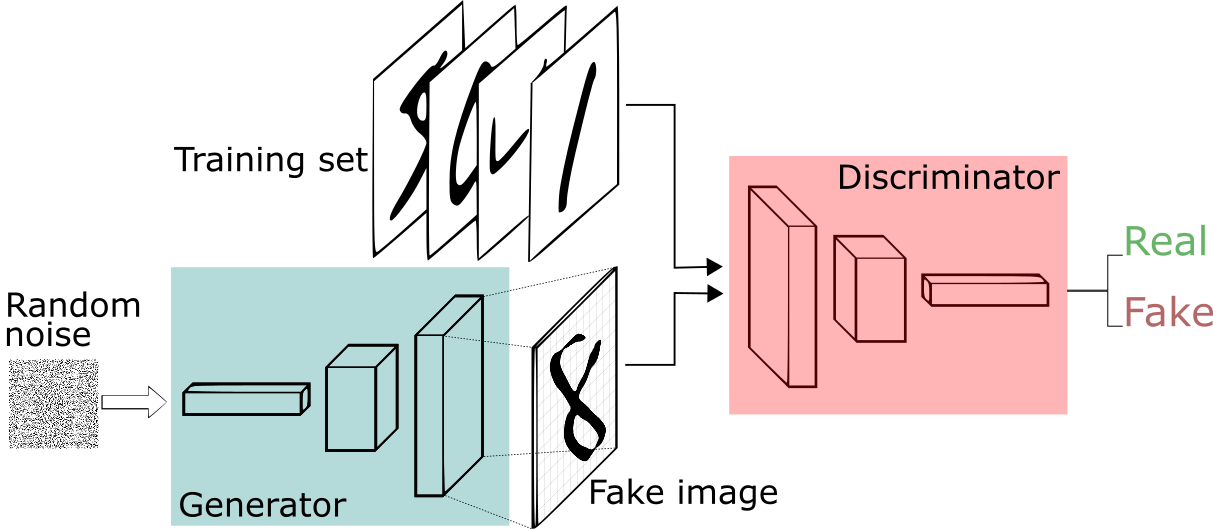

A generative adversarial network (GAN) is a generative model composed of two neural networks: a generator and a discriminator. These two networks are trained in unsupervised way via competition. The generator creates ”realistic” fake images from random noise to fool the discriminator, while the discriminator evaluates the given image for authenticity. 
The loss function that the generator wants to minimize and the discriminator to maximize is as follows: 

min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))] 

Here, G and D are the generator and the discriminator. The first and second term of the loss represent the correct prediction of the discriminator on the real images and on the fake images respectively. 




## DCGAN

• You will implement deep convolutional GAN model on the MNIST dataset with Pytorch. The input image size is 28 x 28. 

• The details of the generator of DCGAN is described below. 

• You will start with batch size of 128, input noise of 100 dimension and Adam optimizer with learning rate of 2e-4. You may vary these hyperparameters for better performance. 

## Architectures


Generator: 

The goal for the generator is to use layers such as convolution, maybe also upsampling layer/transposedConvolution to produce image from the given input noise vector. As this is DCGAN (deep convolutional GAN), we expect you to use convolution in the generator. You will get full credit if you can produce `[batchsize, 1, 28, 28]` vector (image) from the given `[batchsize, 100, 1, 1]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.UpsamplingBilinear2d

• torch.nn.ConvTranspose2d

Non-linear layer: 
 
• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Tanh for the last layer's activation. Can you explain why do we need this in the code comment?


You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

We recommend to use 2 Conv/TransposedConv layers. When you are increasing the feature map size, considering upsample the feature by a factor of 2 each time. If you have width of 7 in one of your feature map, to get output with width of 28, you can do upsampling with factor of 2 and upsampling 2 times. 

Discriminator:

You will get full credit if you can produce an output of `[batchsize, 1]` vector (image) from the given input `[batchsize, 1, 28, 28]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.Linear

Non-linear Layers: 

• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Sigmoid for the last layer's activation. Can you explain why do we need this in the code comment?

Use Leaky ReLu as the activation function between all layers, except after the last layer use Sigmoid.

You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

As an example, you may use 2 convolution layer and one linear layer in the discriminator, you can also use other setup. Note that instead of using pooling to downsampling, you may also use stride=2 in convolution to downsample the feature.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([
                               transforms.ToTensor(),
      ## TODO: Normalization for the dataset: 
      ## Normalize the image into [-1,1] range. This is recommended as the tanh function produces output in this range.
                               ])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)



## 1. Model Definition (TODO)

In [ ]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()

        ################################
        # Please fill in your code here:
        ################################
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 5, 2,  bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, 6, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, 1,  bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, 4, 2, bias=False),
            nn.Tanh()
        )

        

    def forward(self, input):

        ################################
        # Please fill in your code here:
        ################################


        # Explain why Tanh is needed for the last layer

        # We should apply Tahn function to ensure the results fall in the range of [-1, 1]
        out = self.gen(input)
        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        ################################
        # Please fill in your code here:
        ################################
        self.dis = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2,  bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, 2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 5, 2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 1, 1, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )
        
    
    def forward(self, input):
        

        ################################
        # Please fill in your code here:
        ################################


        # Explain why Sigmoid is needed for the last layer
        
        # The output of discriminator is doing classficiation task which is essentially 0 and 1 label, so 
        # we use sigmod to ensure the value falls in the range of [0,1]

        out = self.dis(input)
        return out


# Code that check size
g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]



d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


## 2. GAN loss (TODO)

In [ ]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images (and remember to detach the gradient from the fake images using detach()!)
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    ################################
    # Please fill in your code here:
    ################################
    real_dis = D(real)
    real_dis = real_dis.view(-1)
    loss_dis_on_real = criterion(real_dis, Valid_label)
    fake_imgs = G(noise)
    fake_dis = D(fake_imgs.detach())
    fake_dis = fake_dis.view(-1)
    loss_dis_on_fake = criterion(fake_dis, Fake_label)
    loss_D = loss_dis_on_real + loss_dis_on_fake

    D.zero_grad()
    loss_D.backward()
    optimizerD.step()
   

    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    
    ################################
    # Please fill in your code here:
    ################################
    fake_img = netD(fake)
    fake_img = fake_img.view(-1)
    loss_G = criterion(fake_img, Valid_label)
    
    netG.zero_grad()
    loss_G.backward()
    optimizerG.step()
    return loss_G

## 3. Training (TODO)

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 5, 5]         640,000
       BatchNorm2d-2            [-1, 256, 5, 5]             512
         LeakyReLU-3            [-1, 256, 5, 5]               0
   ConvTranspose2d-4          [-1, 128, 10, 10]       1,179,648
       BatchNorm2d-5          [-1, 128, 10, 10]             256
         LeakyReLU-6          [-1, 128, 10, 10]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]         131,072
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         LeakyReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,024
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 1,952,640
Trainable params: 1,952,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

[0/10][0/600]	Loss_D: 1.4280	Loss_G: 0.6811	
[0/10][50/600]	Loss_D: 1.2968	Loss_G: 0.7934	
[0/10][100/600]	Loss_D: 1.2028	Loss_G: 0.8802	
[0/10][150/600]	Loss_D: 1.0900	Loss_G: 0.9596	
[0/10][200/600]	Loss_D: 1.0288	Loss_G: 1.0476	
[0/10][250/600]	Loss_D: 1.0283	Loss_G: 1.1027	
[0/10][300/600]	Loss_D: 1.1269	Loss_G: 0.9801	
[0/10][350/600]	Loss_D: 1.0825	Loss_G: 0.9164	
[0/10][400/600]	Loss_D: 1.1373	Loss_G: 0.9303	
[0/10][450/600]	Loss_D: 1.1435	Loss_G: 0.9374	
[0/10][500/600]	Loss_D: 1.1766	Loss_G: 0.9762	
[0/10][550/600]	Loss_D: 1.0555	Loss_G: 0.9505	
[1/10][0/600]	Loss_D: 1.1345	Loss_G: 0.9938	
[1/10][50/600]	Loss_D: 1.1026	Loss_G: 1.0756	
[1/10][100/600]	Loss_D: 1.1151	Loss_G: 1.0067	
[1/10][150/600]	Loss_D: 1.0807	Loss_G: 1.0947	
[1/10][200/600]	Loss_D: 1.2010	Loss_G: 1.0448	
[1/10][250/600]	Loss_D: 1.0666	Loss_G: 1.0260	
[1/10][300/600]	Loss_D: 1.0492	Loss_G: 1.0026	
[1/10][350/600]	Loss_D: 1.0417	Loss_G: 1.0269	
[1/10][400/600]	Loss_D: 1.0472	Loss_G: 1.1014	
[1/10][450/600]	Los

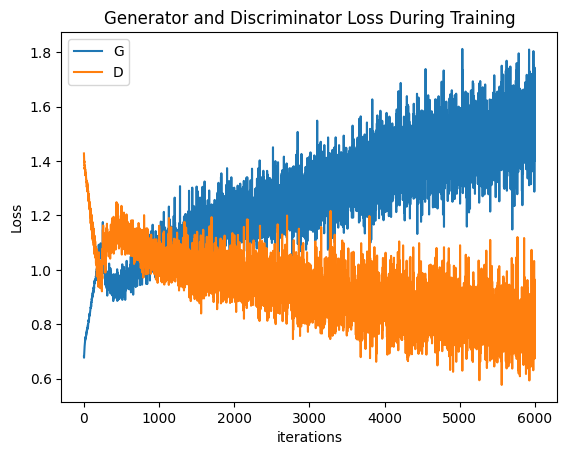

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D

################################
# Please fill in your code here:

optimizerD =  optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

################################



img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 10

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
      

        ################################
        # Please fill in your code here:
        ################################
        loss_D, fake_img = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion, optimizerD)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        ################################
        # Please fill in your code here:
        ################################
        loss_G = loss_generator(netD, netG, fake_img, Valid_label, criterion, optimizerG)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))




## 4. Qualitative Visualisations

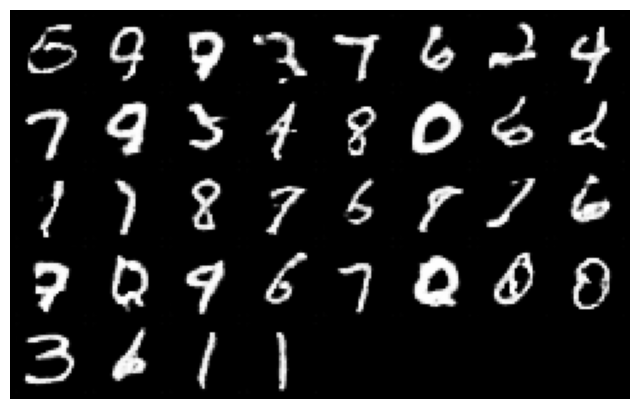

In [ ]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/drive');
!sudo apt-get update;
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic;
!jupyter nbconvert --to pdf /content/drive/MyDrive/Colab\ Notebooks/HW4_COMS4732_yj2737.ipynb;